In [12]:
import sys
!{sys.executable} -m pip install --user keras tensorflow

In [1]:
import os
import hashlib
import zipfile
import requests

import keras
import numpy as np
import pandas as pd
from scipy import ndimage
from sklearn import decomposition

from skimage import io
from skimage import filters

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 0. A brief introduction to deep learning

- Ultrahigh Carbon Steel microstructure dataset
- texture features: Gabor filters
- pre-trained convolutional neural nets as fixed feature extractors

For a more thorough tutorial, read through https://cs231n.github.io/, or watch the associated lectures on youtube.

For state-of-the-art (2018) practical deep learning, see https://fast.ai

For more in-depth discussion from a theoretical/mathematical perspective, see http://deeplearningbook.org.

### More resources

For mathematical background: [arXiv:1802.01528](https://arxiv.org/abs/1802.01528)

Also of interest: comp.ai.neural-nets FAQ (last updated 2002): http://www.faqs.org/faqs/ai-faq/neural-nets/part1/index.html

Also: http://colah.github.io/posts/2015-08-Backprop/

Interactive ConvNets in the browser: https://cs.stanford.edu/people/karpathy/convnetjs/

[Blog post on transfer learning](https://medium.com/nanonets/nanonets-how-to-use-deep-learning-when-you-have-limited-data-f68c0b512cab)



## 1. Download images and metadata for the UHCS microstructure dataset

https://dx.doi.org/10.1016/j.actamat.2017.05.014

http://uhcsdb.materials.cmu.edu

https://materialsdata.nist.gov/dspace/xmlui/bitstream/handle/11256/940/

- `micrographs.zip`: compressed SEM micrographs (download from materialsdata.nist.gov)
- `uhcs-metadata.csv`: imaging and processing metadata (download from github -- simpler to load than sqlite available from materialsdata.nist.gov)

In [11]:
def check_hash(file_path, checksum):
    """ return True if md5 hash matches checksum """
    return hashlib.md5(open(file_path, 'rb').read()).hexdigest() == checksum

def stream_file(filename, checksum, data_dir='data', base_url='https://materialsdata.nist.gov/dspace/xmlui/bitstream/handle/11256/940/'):
    """ stream data files from NIST -- only if they haven't been downloaded yet """
    
    url = base_url + filename
    datafile = os.path.join(data_dir, filename)
    
    os.makedirs(data_dir, exist_ok=True)

    # only download files if they aren't already available, or if their md5sum isn't as expected...
    if (not os.path.isfile(datafile)) or (not check_hash(datafile, checksum)):
        print('downloading', datafile, 'from', url)
        response = requests.get(url, stream=True)
        with open(datafile, "wb") as f:
            for chunk in response.iter_content(chunk_size=512):
                if chunk:
                    f.write(chunk)
    else:
        print(datafile, 'already downloaded')

def load_compressed_image(image_path, archive_path='data/micrographs.zip'):
    """ decompress and load a single image from a zip archive """
    with zipfile.ZipFile(archive_path, 'r') as f:
        return io.imread(f.open('micrographs/' + image_path))

In [3]:
images_checksum = 'd139cf1ce463922bdad9472ca508eb0d'
readme_checksum = 'da2addce9e15fccfabd55927ffd318a4'
csv_checksum = '3d3481b344b529372efc541a353f4288'

stream_file('README.md', readme_checksum)
stream_file('micrographs.zip', images_checksum)
stream_file('uhcs-metadata.csv', csv_checksum, base_url='https://raw.githubusercontent.com/bdecost/uhcsdb/master/data/')

downloading data\README.md from https://materialsdata.nist.gov/dspace/xmlui/bitstream/handle/11256/940/README.md
downloading data\micrographs.zip from https://materialsdata.nist.gov/dspace/xmlui/bitstream/handle/11256/940/micrographs.zip
downloading data\uhcs-metadata.csv from https://raw.githubusercontent.com/bdecost/uhcsdb/master/data/uhcs-metadata.csv


## 2. load metadata and explore a bit

In [5]:
df = pd.read_csv('data/uhcs-metadata.csv', index_col=0)
df.set_index('micrograph_id', inplace=True)

# filter down to the images used in the paper...
label_set = ['spheroidite', 'spheroidite+widmanstatten', 'martensite', 'network', 'pearlite', 'pearlite+spheroidite', 'pearlite+widmanstatten']
df = df[df.primary_microconstituent.isin(label_set)]

df.head()

anneal_temp_unit  anneal_temperature  anneal_time  \
micrograph_id                                                     
1                          NaN                 NaN          NaN   
2                            C               800.0         85.0   
4                            C               970.0         90.0   
5                            C               750.0          5.0   
6                            C               970.0         90.0   

              anneal_time_unit  contributor_key cool_method detector  \
micrograph_id                                                          
1                          NaN                2         NaN       SE   
2                            H                2           Q       SE   
4                            M                2          FC       SE   
5                            M                2           Q       SE   
6                            M                2          AR       SE   

                         label magnification  micron_bar  micron_bar_px  \
micrograph_id                                                             
1                      ET Gyro         4910x         5.0            129   
2               AC1 800C 85H Q         1964X        10.0            103   
4              AC1 970C 90M FC           NaN        10.0            129   
5                AC1 750C 5M Q         4910X         5.0            129   
6              AC1 970C 90M AR         1178X        20.0            124   

              micron_bar_units             path primary_microconstituent  \
micrograph_id                                                              
1                           um  micrograph1.tif                 pearlite   
2                           um  micrograph2.tif              spheroidite   
4                           um  micrograph4.tif     pearlite+spheroidite   
5                           um  micrograph5.tif                 pearlite   
6                           um  micrograph6.tif              spheroidite   

               sample_id  sample_key  
micrograph_id                         
1                   42.0        42.0  
2                   18.0        18.0  
4                   35.0        35.0  
5                   10.0        10.0  
6                   29.0        29.0

In [9]:
# adjust annealing time units
print(df.anneal_time_unit.unique())

a = np.ones_like(df.anneal_time)
a[df.anneal_time_unit == 'M'] = 1/60
df['anneal_hours'] = a * df.anneal_time

[nan 'H' 'M']


BadZipFile: File is not a zip file

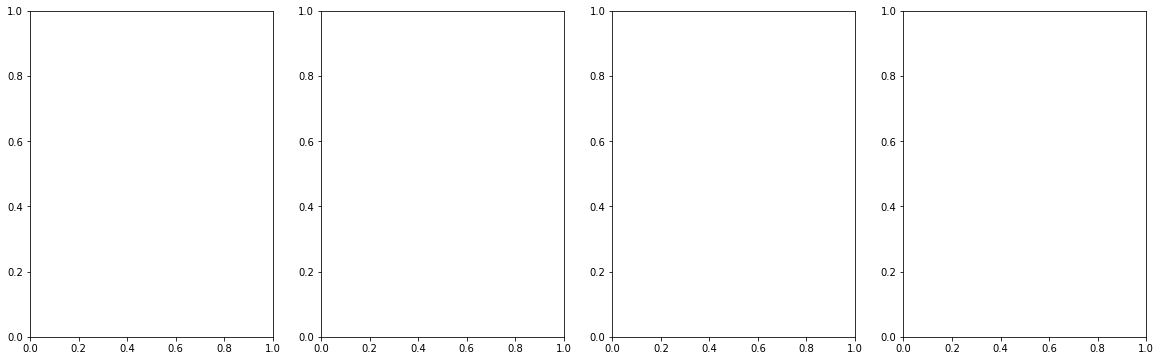

In [10]:
# draw a couple random images
fig, axes = plt.subplots(ncols=4, figsize=(20,6))

for ax, (idx, row) in zip(axes, df.sample(4).iterrows()):
    im = load_compressed_image(row.path)
    ax.imshow(im, origin='upper', cmap='gray', aspect='equal')
    ax.set_title('{primary_microconstituent}: {anneal_temperature} {anneal_temp_unit} {anneal_time}{anneal_time_unit}'.format(**row.to_dict()))
    ax.axis('off')
    
plt.tight_layout()

## 3. let's do some filtering

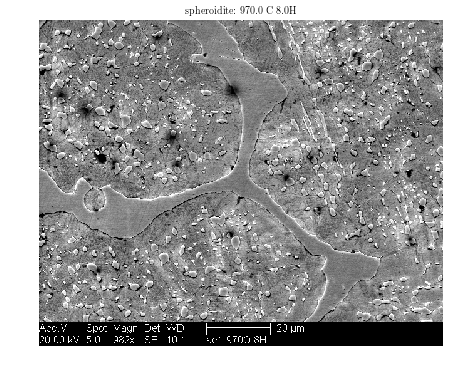

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
idx = 1682
row = df.loc[idx]

im = load_compressed_image(row.path)
ax.imshow(im, origin='upper', cmap='gray', aspect='equal')
ax.set_title('{primary_microconstituent}: {anneal_temperature} {anneal_temp_unit} {anneal_time}{anneal_time_unit}'.format(**row.to_dict()))
ax.axis('off');

We should throw away the micron bar...

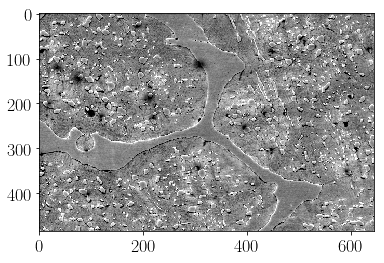

In [8]:
micron_bar_height = 38 # 38 px is the magic number for this SEM...
plt.imshow(im[:-micron_bar_height], cmap='gray', origin='upper')

### Basic texture features: Gabor filters
- basically 2D harmonic functions modulated by a gaussian envelope...
- functionally, they do smoothing and edge detection

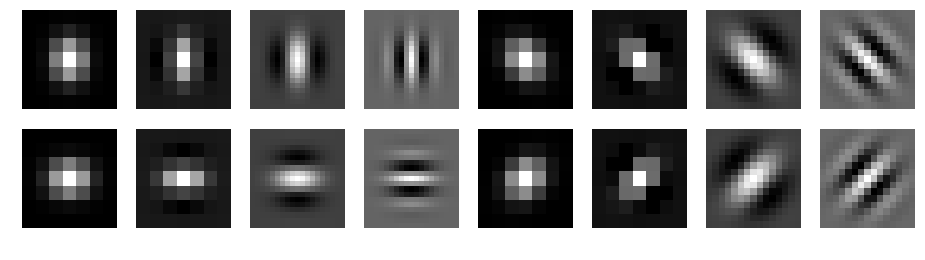

In [10]:
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.1, 0.2):
            kernel = np.real(
                filters.gabor_kernel(frequency, theta=theta,
                                     sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)
            
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16,4))
for ax, kernel in zip(axes.flat, kernels):
    ax.imshow(kernel, cmap='gray')
    ax.axis('off')

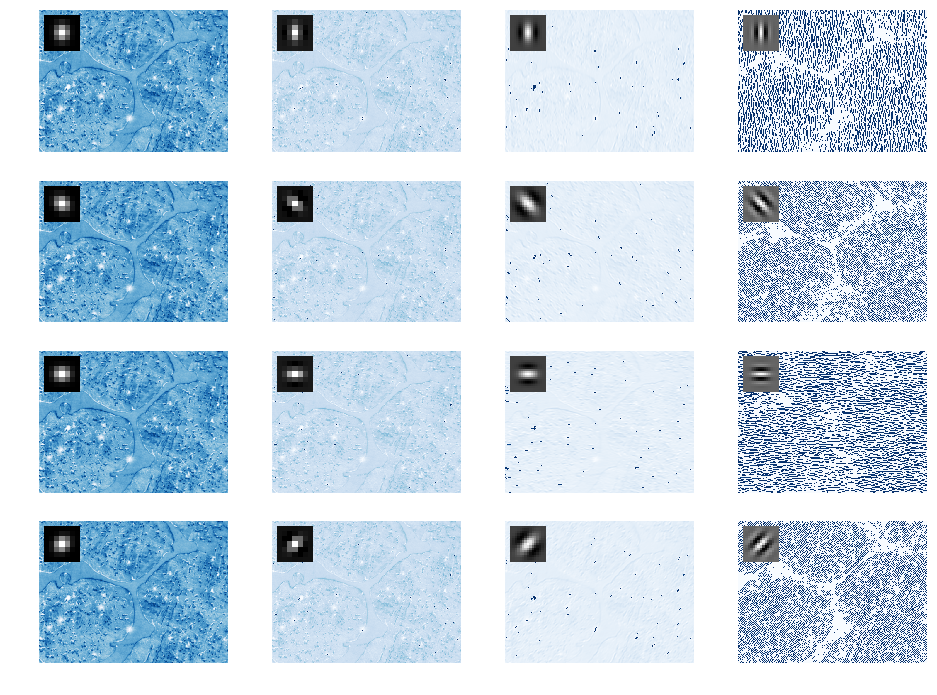

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,12))
for ax, kernel in zip(axes.flat, kernels):
    f = ndimage.convolve(im[:-micron_bar_height], kernel, mode='mirror')
    ax.imshow(f, origin='lower', aspect='equal', cmap='Blues')
    ax.axis('off')
    
    inset = inset_axes(ax, width=0.5, height=0.5, loc=2)
    inset.imshow(kernel, cmap='gray')
    inset.axis('off')

## 4. At their most basic, convolutional neural nets are just hierarchical versions of this...

Deep neural networks can model very complicated data and distributions, but their basic building blocks are actually quite simple.

Most deep learning models look like stacks of functions, where each layer (function) operates on the output of the previous intermediate layer (function).

$\hat{y} = f(x) = h_3( \; h_2( \; h_1(x) \; ) \; )$

$h_i(x) = \sigma(z_i) = \sigma(W_i x + b)$

This is just a linear function applied to $z$ (multiplication by a *weights* matrix $W$ and addition of a *bias* vector $b$), where the result is passed through a non-linear *activation* function $\sigma$, such as `tanh` or `ReLU`$(z) = max(0, z)$.

A deep learning model is just a large composite function made up of basic building blocks like these, where the parameters $W_i$ and $b_i$ are "learned" from training data.

Briefly, these parameters are found by differentiating the model cost function w.r.t. the parameters and optimizing via gradient descent (applying the chain rule layer by layer back to the inputs, i.e. *backpropagation*).

In [12]:
import keras
from keras_applications import vgg16
base_model = vgg16.VGG16(include_top=False, weights='imagenet', pooling='avg')
base_model.summary()

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Convolutional neural networks
Convolution layers: parameter sharing and translation-invariance.
Spatial pooling: increases field of view, reduced dimensionality for fully-connected layers.

<a href="https://dx.doi.org/10.1038/nature14539"><img width=70% src="figures/cnn-schematic.png" ></a>

More detailed post by Chris Olah: http://colah.github.io/posts/2014-07-Understanding-Convolutions/

### visualizing CNN filters and representations
Visualizing deep convolutional neural networks using natural pre-images [arXiv:1512.02017](https://arxiv.org/abs/1512.02017)
<a href="https://arxiv.org/abs/1311.2901"><img width=60% src="figures/preimage.png" ></a>

More resources:
- Landmark paper: Visualizing and understanding convolutional neural networks [arXiv:1311.2901](https://arxiv.org/abs/1311.2901)
- Great interactive paper in distill: https://distill.pub/2017/feature-visualization/
- Nils Persson's web app http://imperssonator.github.io/
- Visual Interpretability for Deep Learning: a Survey [arXiv:1802.00614](https://arxiv.org/abs/1802.00614)

### A note on preprocessing

In [51]:
from sklearn import decomposition

def to_tensor(im):
    """ to keras tensor, including standardization for ImageNet weights """
    
    im = im.astype(float)
    
    # stack grayscale image to get channels-first RGB image...
    x = np.tile(im[:-micron_bar_height], (3,1,1))
    
    # with tf backend, keras wants channels last
    if keras.backend.image_data_format() == 'channels_last':
        x = x.transpose(1,2,0)
    
    # apply ImageNet standardization
    x = vgg16.preprocess_input(x)
    
    return x

def visualize_activations(act, mode='clip'):
    """ apply PCA along channel dimension of activation tensor to visualize activations as RGB image """
    b, h, w, c = act.shape
    x = act.reshape((-1,c))
    x.shape
    x_reduced = decomposition.PCA(n_components=3, whiten=True).fit_transform(x)
    
    if mode == 'clip':
        return np.clip(x_reduced, 0, 1).reshape((h,w,3))
    elif mode == 'scale':
        # rescale to roughly [-1, 1]
        c = x_reduced / np.max(np.abs(x_reduced))
    
        # shift and clip to [0, 1]
        c = np.clip((c + 1) / 2, 0, 1)
        return c.reshape((h,w,3))

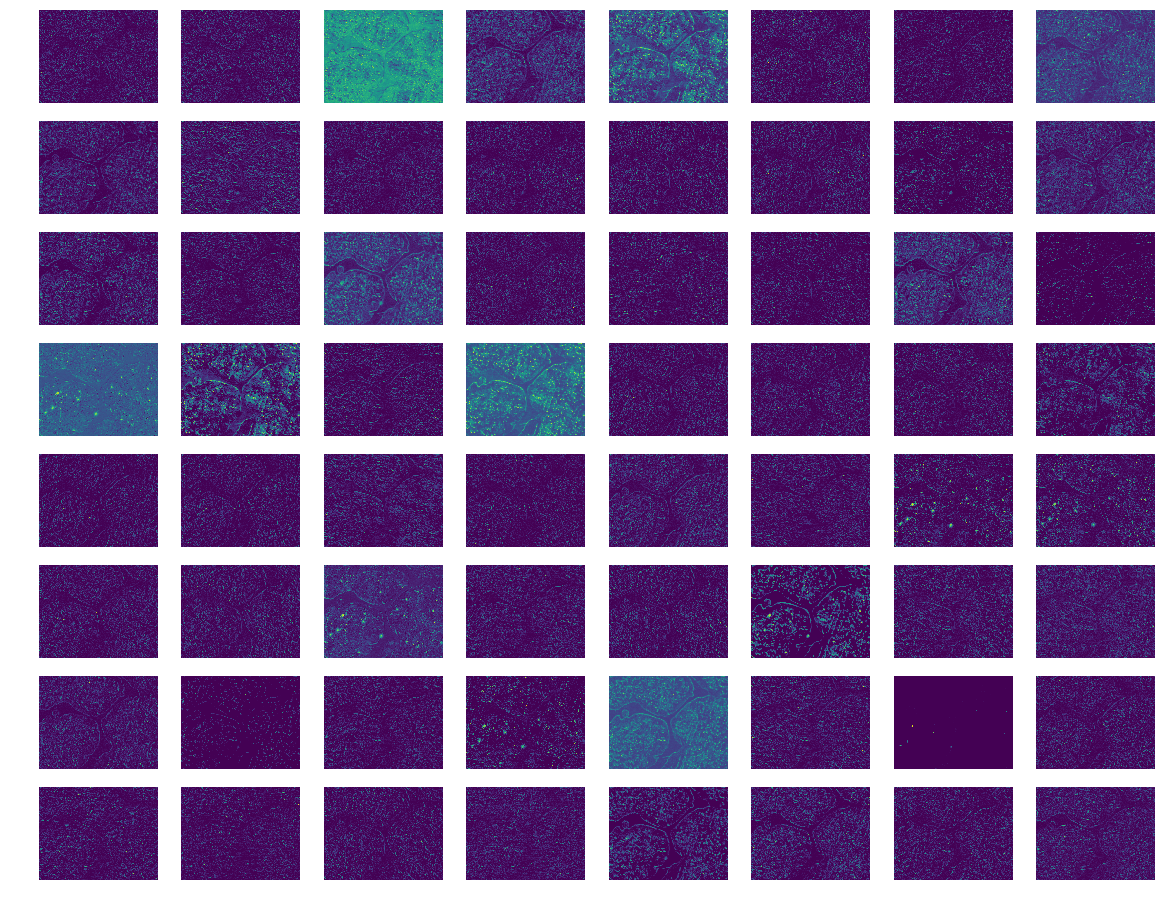

In [14]:
model = keras.models.Model(base_model.inputs, base_model.get_layer('block1_conv2').output)
act = model.predict(to_tensor(im)[None,...])

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20,16))

for idx, ax in enumerate(axes.flat):
    ax.imshow(act[0,...,idx], interpolation='none')
    ax.axis('off')

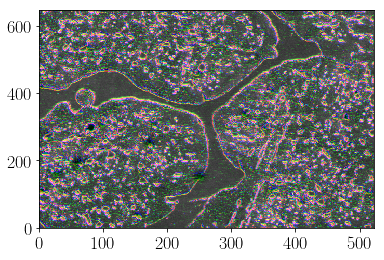

In [131]:
plt.imshow(im[:-micron_bar_height], extent=extent, cmap='gray')
plt.imshow(
    visualize_activations(act, mode='clip'),
    alpha=0.5,
    extent=extent
);

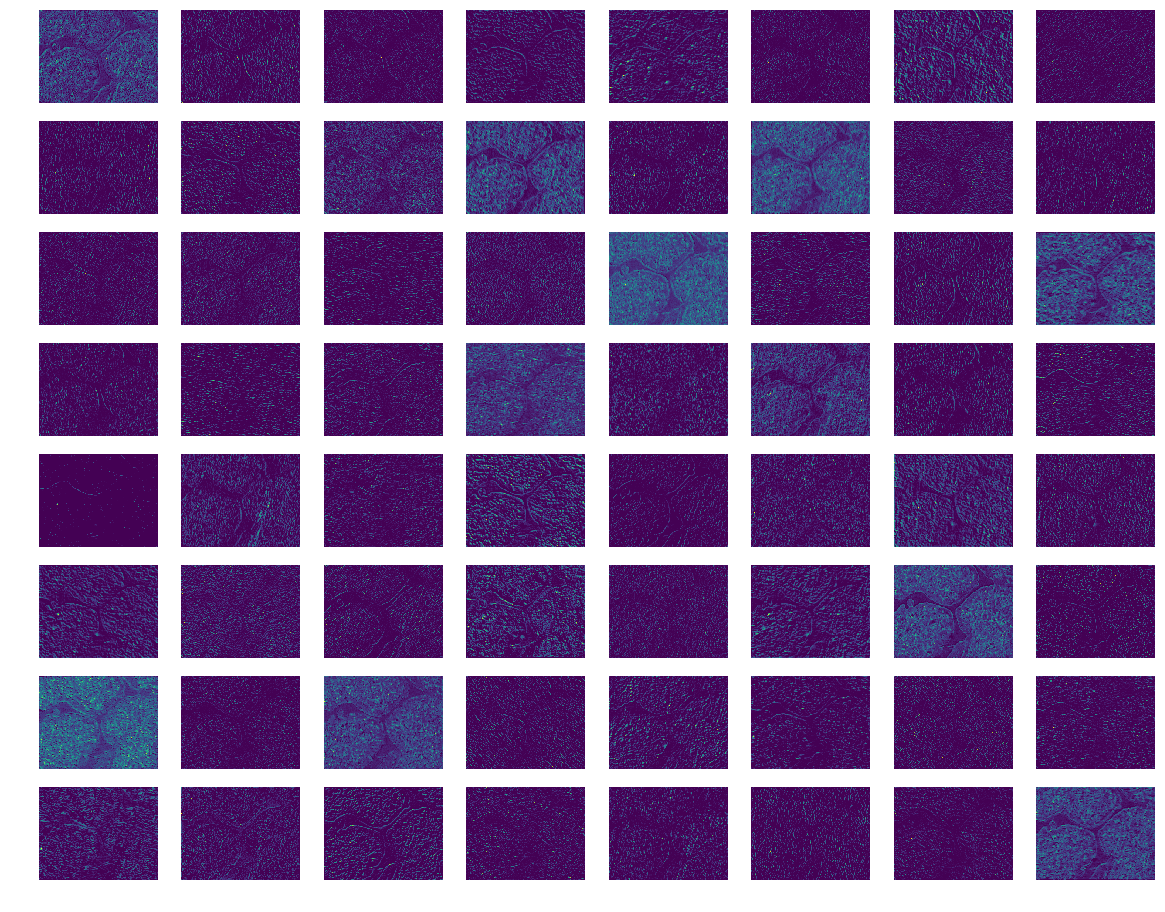

In [128]:
model = keras.models.Model(base_model.inputs, base_model.get_layer('block2_conv2').output)
act = model.predict(to_tensor(im)[None,...])

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20,16))

for idx, ax in enumerate(axes.flat):
    ax.imshow(act[0,...,idx], interpolation='none')
    ax.axis('off')

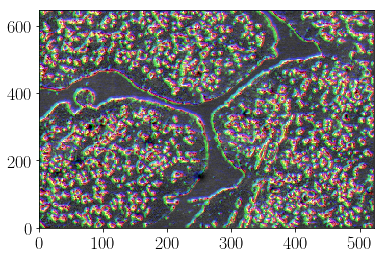

In [129]:
plt.imshow(im[:-micron_bar_height], extent=extent, cmap='gray')
plt.imshow(
    visualize_activations(act, mode='clip'),
    alpha=0.5,
    extent=extent
);

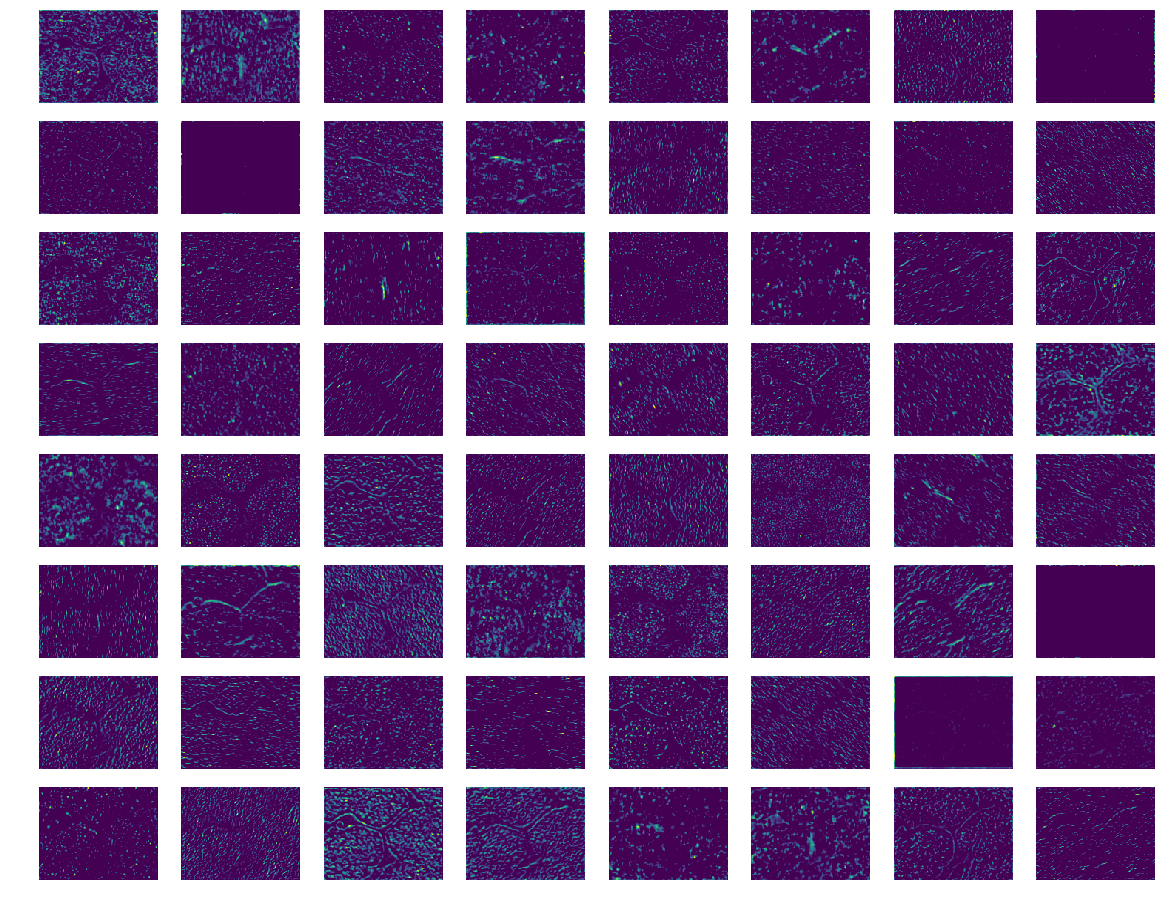

In [126]:
model = keras.models.Model(base_model.inputs, base_model.get_layer('block3_conv3').output)
act = model.predict(to_tensor(im)[None,...])

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20,16))

for idx, ax in enumerate(axes.flat):
    ax.imshow(act[0,...,idx], interpolation='none')
    ax.axis('off')

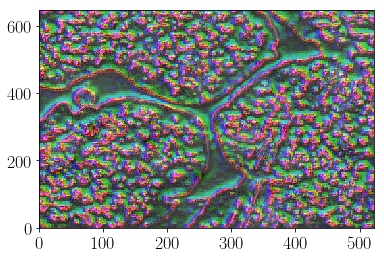

In [127]:
plt.imshow(im[:-micron_bar_height], extent=extent, cmap='gray')
plt.imshow(
    visualize_activations(act, mode='clip'),
    alpha=0.5,
    extent=extent
);

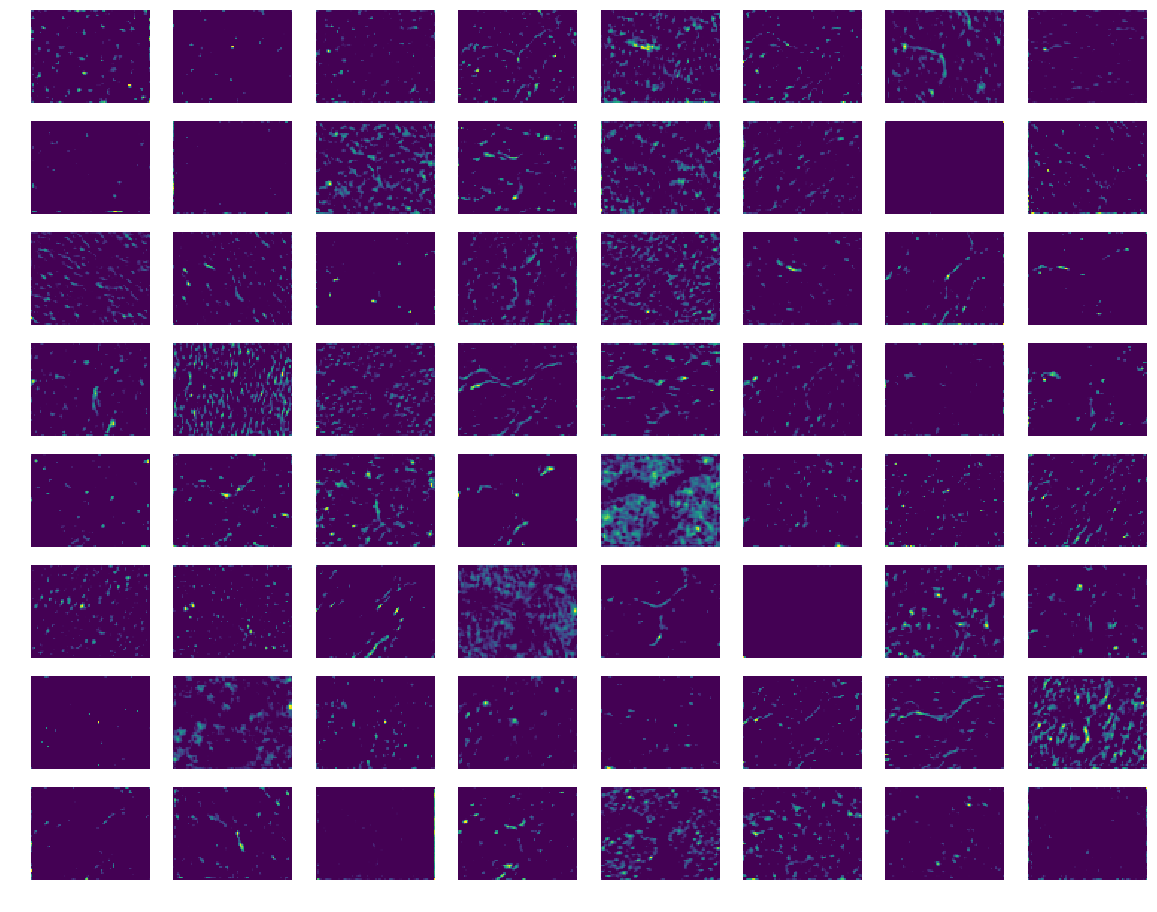

In [122]:
model = keras.models.Model(base_model.inputs, base_model.get_layer('block4_conv3').output)
act = model.predict(to_tensor(im)[None,...])

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20,16))

for idx, ax in enumerate(axes.flat):
    ax.imshow(act[0,...,idx], interpolation='none')
    ax.axis('off')

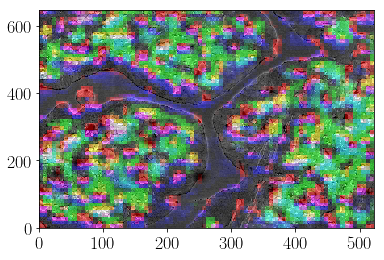

In [125]:
plt.imshow(im[:-micron_bar_height], extent=extent, cmap='gray')
plt.imshow(
    visualize_activations(act, mode='clip'),
    alpha=0.5,
    extent=extent
);

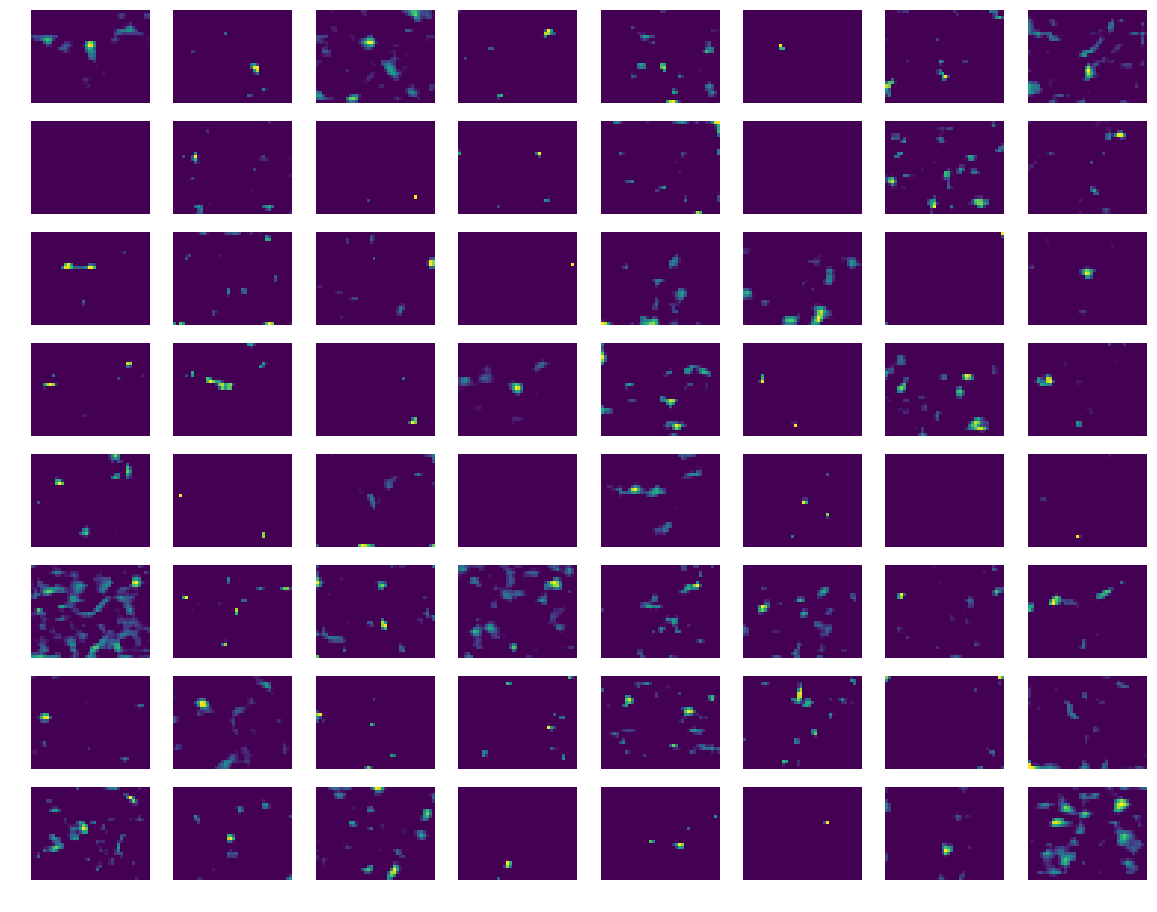

In [132]:
model = keras.models.Model(base_model.inputs, base_model.get_layer('block5_conv3').output)
act = model.predict(to_tensor(im)[None,...])

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20,16))

for idx, ax in enumerate(axes.flat):
    ax.imshow(act[0,...,idx], interpolation='none')
    ax.axis('off')

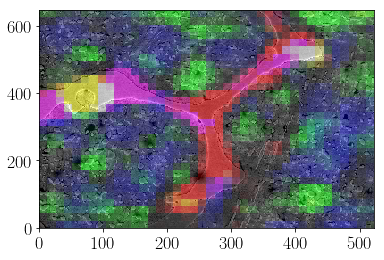

In [133]:
plt.imshow(im[:-micron_bar_height], extent=extent, cmap='gray')
plt.imshow(
    visualize_activations(act, mode='clip'),
    alpha=0.5,
    extent=extent
);

## extract image-level pre-trained CNN features

This can be slow on CPU -- check out [uhcsdb.materials.cmu.edu/visualize](http://uhcsdb.materials.cmu.edu/visualize) for interactive visualizations...

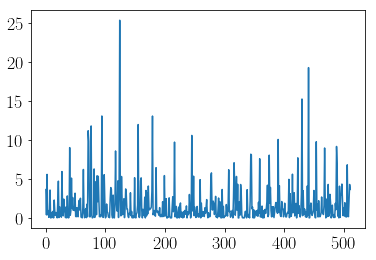

In [16]:
o = base_model.predict(to_tensor(im)[None,...])
plt.plot(o.squeeze())

In [52]:
# load and preprocess all the images, then push them through the network in batches...
# sample some images where processing metadata is available...

# 256 samples takes a bit more than 2 minutes on my laptop...
n_samples = 256
# sample = df[~pd.isna(df.anneal_temperature)].sample(n_samples)

# all samples with metadata takes around 5 minutes...
sample =df[~pd.isna(df.anneal_temperature)]

x = []
for idx, row in sample.iterrows():
    im = load_compressed_image(row.path)
    x.append(to_tensor(im))
    
# concatenate all the image tensors along a new batch axis
x = np.stack(x)

In [53]:
# crop out the central 256x256 patch of the images...
b, h, w, c = x.shape
h_start, h_end = h // 2 - 128, h // 2 + 128
w_start, w_end = w // 2 - 128, w // 2 + 128

xx = x[:,h_start:h_end,w_start:w_end,:]
xx.shape

(598, 256, 256, 3)

In [54]:
Z = base_model.predict(xx, verbose=True, batch_size=4)

598/598 [==============================] - 332s 555ms/step


In [55]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
X_pca = pca.fit_transform(Z)

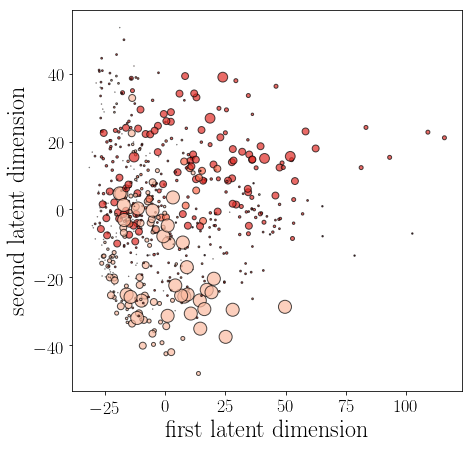

In [56]:
plt.figure(figsize=(7,7))
missing_md = pd.isna(sample.anneal_temperature)

plt.scatter(X_pca[~missing_md,0], X_pca[~missing_md,1], 
            c=sample.anneal_temperature[~missing_md], s=2*sample.anneal_hours[~missing_md], 
            cmap='Reds', alpha=0.7, edgecolors='k')
plt.scatter(X_pca[missing_md,0], X_pca[missing_md,1], color='k', s=1)
plt.xlabel('first latent dimension')
plt.ylabel('second latent dimension');

In [57]:
from sklearn import manifold
mds = manifold.MDS()
X_mds = mds.fit_transform(Z)

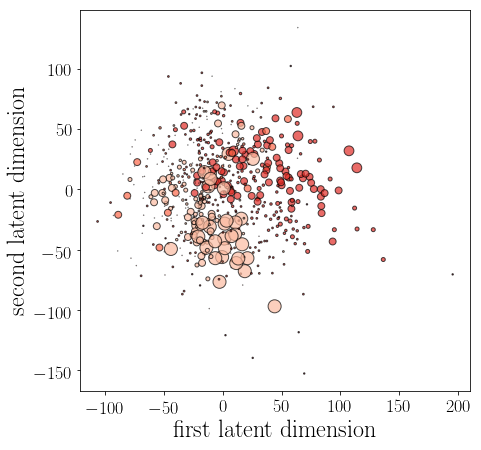

In [61]:
plt.figure(figsize=(7,7))
missing_md = pd.isna(sample.anneal_temperature)

plt.scatter(X_mds[~missing_md,0], X_mds[~missing_md,1],
            c=sample.anneal_temperature[~missing_md], s=2*sample.anneal_hours[~missing_md],
            cmap='Reds', alpha=0.7, edgecolors='k')
plt.scatter(X_mds[missing_md,0], X_mds[missing_md,1], color='k', s=1)
plt.xlabel('first latent dimension')
plt.ylabel('second latent dimension');